# **Analisis dan Prediksi IHSG Menggunakan Pendekatan Time Series**

Tujuan :  membuat model yang dapat memprediksi IHSG yang memanfaatkan data historis sehingga dapat memberikan gambaran awal mengenai pergerakan indeks IHSG.


# Import Library

Instalisasi Library yang akan digunakan untuk mendukung proses analisis ini

In [25]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, LSTM
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

# Load and Understanding Data

Sumber dataseet IHSG : https://id.investing.com/indices/idx-composite

Dataset dimuat berikut:
- data_ihsg1 : dataset IHSG dari tahun 1990-2010
- data_ihsg2 : dataset IHSG dari tahun 2011- mei 2025

In [2]:
data_ihsg1 = pd.read_csv("https://raw.githubusercontent.com/ejapten/Predictive-Analysis-IHSG-TimeSeries/refs/heads/main/raw_dataset/1990_2010_IHSG.csv")
data_ihsg2 = pd.read_csv("https://raw.githubusercontent.com/ejapten/Predictive-Analysis-IHSG-TimeSeries/refs/heads/main/raw_dataset/2011_2025_IHSG%20.csv")


dataset digabungkan karena konteks data tersebut sama dan memudahkan untuk menganalisis data IHSG, dataset IHSG tersebut sama hanya saja periode waktu yang berda

In [3]:
data_ihsg = pd.concat([data_ihsg1,data_ihsg2])
data_ihsg

,Date,Price,Open,High,Low,Vol.,Change %
0,09/28/2010,"3,472.71","3,468.23","3,524.32","3,455.50",6.18B,0.13%
1,09/27/2010,"3,468.04","3,397.82","3,472.03","3,397.82",6.05B,2.07%
2,09/24/2010,"3,397.63","3,338.71","3,400.56","3,331.86",4.98B,1.81%
3,09/23/2010,"3,337.20","3,343.83","3,351.39","3,313.31",7.51B,-0.18%
4,09/22/2010,"3,343.34","3,365.13","3,380.20","3,332.27",11.22B,-0.64%
...,...,...,...,...,...,...,...
3496,01/07/2011,"3,631.45","3,734.37","3,734.37","3,607.33",3.64B,-2.81%
3497,01/06/2011,"3,736.26","3,782.99","3,789.47","3,720.57",2.88B,-1.25%
3498,01/05/2011,"3,783.71","3,759.97","3,786.05","3,728.91",3.36B,0.63%
3499,01/04/2011,"3,760.06","3,727.80","3,763.38","3,724.47",5.31B,0.87%


In [4]:
data_ihsg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8500 entries, 0 to 3500
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      8500 non-null   object
 1   Price     8500 non-null   object
 2   Open      8500 non-null   object
 3   High      8500 non-null   object
 4   Low       8500 non-null   object
 5   Vol.      7816 non-null   object
 6   Change %  8500 non-null   object
dtypes: object(7)
memory usage: 789.3+ KB


Setelah mengecek tipe data, ternyata semua variable bertipe data object

In [5]:
data_ihsg.isnull().sum()

,0
Date,0
Price,0
Open,0
High,0
Low,0
Vol.,684
Change %,0


Hanya variable Vol. saja yang memiliki Missing Value

In [6]:
data_ihsg.duplicated().sum()

np.int64(0)

Dalam data tersebut tidak memilik duplikat data

# Cleaning Data

Membuat fungsi cleaning untuk membersihkan data

In [7]:
# Fungsi menghapus missing value
def delete_missing_value(df):
  cleaned_mv = df.dropna()
  return cleaned_mv

# Fungsi menghapus variable/Kolom
def delete_columns(df, columns_to_delete):
  del_columns = df.drop(columns_to_delete, axis=1)
  return del_columns

#  Fungsi untuk konversi tipe data menjadi tanggal
def convert_to_datetime(df, col_name):
  df[col_name] = pd.to_datetime(df[col_name], format="%m/%d/%Y")
  return df
# Fungsi Untuk mengurutkan tanggal
def convert_and_sort_datetime(df, col_name):
  df[col_name] = pd.to_datetime(df[col_name], format="%m/%d/%Y")
  df = df.sort_values(by=col_name)
  df = df.reset_index(drop=True)
  return df

# Fungsi untuk konversi tipe data menjadi float dimana nilai unique sebelumnya bersifat
def convert_price_to_float(df, col_name):
  df[col_name] = df[col_name].str.replace(",", "").astype(float)
  return df
# Fungsi Untuk konversi tipe data menjadi float dimana nilai unique sebelumnya memiliki simbol %
def convert_percent_to_float(df, col_name):
    df[col_name] = df[col_name].str.replace("%", "").astype(float) / 100
    return df

In [8]:
# Apply Fungsi Cleaning
columns_to_delete = ["Open", "High", "Low", "Vol."] # Variable yang akan di delete

data_ihsg = delete_missing_value(data_ihsg)
data_ihsg = delete_columns(data_ihsg, columns_to_delete)
data_ihsg = convert_to_datetime(data_ihsg, "Date")
data_ihsg = convert_and_sort_datetime(data_ihsg, "Date")
data_ihsg = convert_price_to_float(data_ihsg, "Price")
data_ihsg = convert_percent_to_float(data_ihsg, "Change %")

Fungsi cleaning diatas digunakan untuk membersihkan data
- Variable Open, High, Low, Vol akn dihapus karena tidak akan dilakukan proses analisis pada proyek kali ini. Namun, Price dan Change % akan dilakukan analisis, dimana Price aka dijadikan sebagai variabel yang akan memprediksi pergerakan IHSG. Sedangkan Change % tidak akan dilakukan prediksi namun digunakan untuk melihat pola pada data IHSG

- Lalu dilakukan konversi tipe data menjadi datetime pada variabel Date dan diurutkan

- Konvers tipe data dilakukan pada Price dan Change % menjadi floatt

# EDA

In [9]:
data_ihsg.shape

(7816, 3)

data setelah dibersihkan berjumlah 7816 dan 3 variable

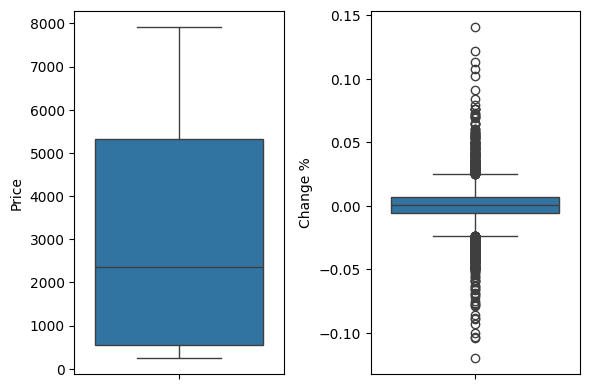

In [10]:
# Melihat outliers
kolom_numerik_eda = data_ihsg.select_dtypes(include='number').columns
# Buat grid
num_cols = len(kolom_numerik_eda)
num_rows = math.ceil(num_cols / 2)
# Visualisasi
plt.figure(figsize=(6, 4 * num_rows))
for i, column in enumerate(kolom_numerik_eda):
    plt.subplot(num_rows, 2, i + 1)
    sns.boxplot(y=data_ihsg[column])
plt.tight_layout()
plt.show()

Dalam variable Price tidak ada Outliers, namun pada variable Change % terdapat outliers. Namun Tidak perlu khawatir terhadap variable Change % karena tidak akan dilakukan prediksi

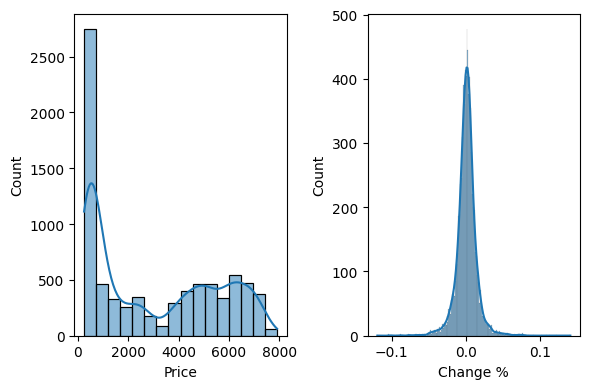

In [11]:
# Melihat persebaran data
num_cols_numeric = len(kolom_numerik_eda)
num_rows_numeric = math.ceil(num_cols_numeric / 2)

plt.figure(figsize=(6, 4 * num_rows_numeric))

for i, column in enumerate(kolom_numerik_eda):
    plt.subplot(num_rows_numeric, 2, i + 1)
    sns.histplot(data=data_ihsg, x=column, kde=True)

plt.tight_layout()
plt.show()

Variable Price berdistribusi tidak normal dan Change % normal

In [12]:
data_ihsg.describe()

,Date,Price,Change %
count,7816,7816.000000,7816.000000
mean,2009-02-07 21:43:06.693961216,3023.570763,0.000505
min,1993-01-04 00:00:00,256.830000,-0.119500
25%,2000-12-07 18:00:00,546.677500,-0.005500
50%,2008-12-25 00:00:00,2349.200000,0.000800
75%,2017-03-30 06:00:00,5330.762500,0.006700
max,2025-05-15 00:00:00,7905.390000,0.140300
std,NaN,2479.113005,0.014021


Dalam data tersebut Tahun dimana data ini dimulai adalah 1993. Lalu Price atau harga IHSG paling tinggi pada angka 7905.39000 dan paling rendah dalam angka 256.83000 Lalu pada Change yang merupakan perubahan pernah turun mencapai -0.11


In [13]:
# Melihat Jumlah Price yang paling banyak berdasarkan Waktu
High_price_based_on_date = (
    data_ihsg
    .groupby("Date")
    .agg({"Price": "sum"})
    .sort_values("Price", ascending=False)
    .head(5)
)
High_price_based_on_date

,Price
Date,
2024-09-19,7905.39
2024-09-17,7831.78
2024-09-18,7829.13
2024-09-13,7812.13
2024-09-12,7798.15


Ternyata Harga IHSG tertingi dari 1990-2025 berada pada tahun 2024 dan sama sama di bulan 9

In [14]:
# Melihat Jumlah Price yang paling sedikit berdasarkan Waktu
low_price_based_on_date = (
    data_ihsg
    .groupby("Date")
    .agg({"Price": "sum"})
    .sort_values("Price", ascending=True)
    .head(5)
)
low_price_based_on_date

,Price
Date,
1998-09-21,256.83
1998-10-06,258.11
1998-09-22,260.88
1998-10-05,261.31
1998-09-23,262.25


  Sedangkan, Harga IHSG terendah dari 1990-2025 berada pada tahun 1998

<ipython-input-15-a10ea947c39c>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=data_ihsg, x="Date", y="Price", palette="tab10")


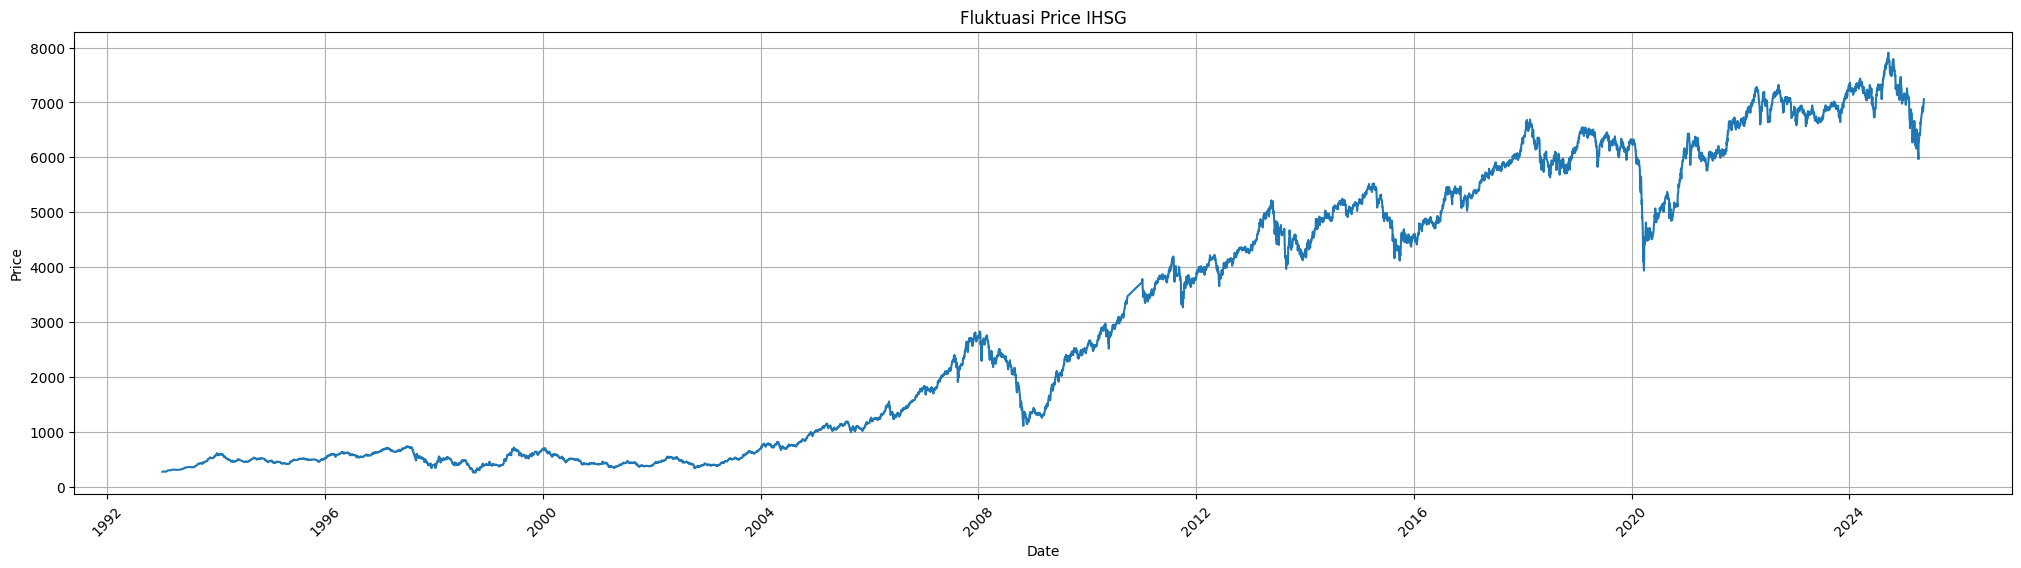

In [15]:
plt.figure(figsize=(25, 6))
sns.lineplot(data=data_ihsg, x="Date", y="Price", palette="tab10")

plt.title("Fluktuasi Price IHSG")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Berdasarkan visualisasi diatas dapat terlihat jelas bahwa IHSG terjadi penurunan pada rentang 1996-2000 dimana kemunginan besar adalah pada 1998. Laluu terjadi penurunan lagi pada rentang 2008-2012 secara tajam.Penurunan secara tajam lagi terjadi pada 2020 hingga kemungkinan 2022. Lalu pada 2025 terjadi penurunan secara tajam lagi pada bulan maret

Selain penurunan, pada 2000 terjadi kenaikan IHSG, lalu pada periode 2011 kemungkinan besar juga mengalami kenaikkan. Lalu rentang 2016-2020 terjadi kenaikan harga yang paling tinggi diantara tahun sebelumnya. Sebelum IHSG merosot turun pada maret 2025 IHSG pernah mengalami kenaikan

<ipython-input-16-af7e263e04e2>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=data_ihsg, x="Date", y="Change %", palette="tab10")


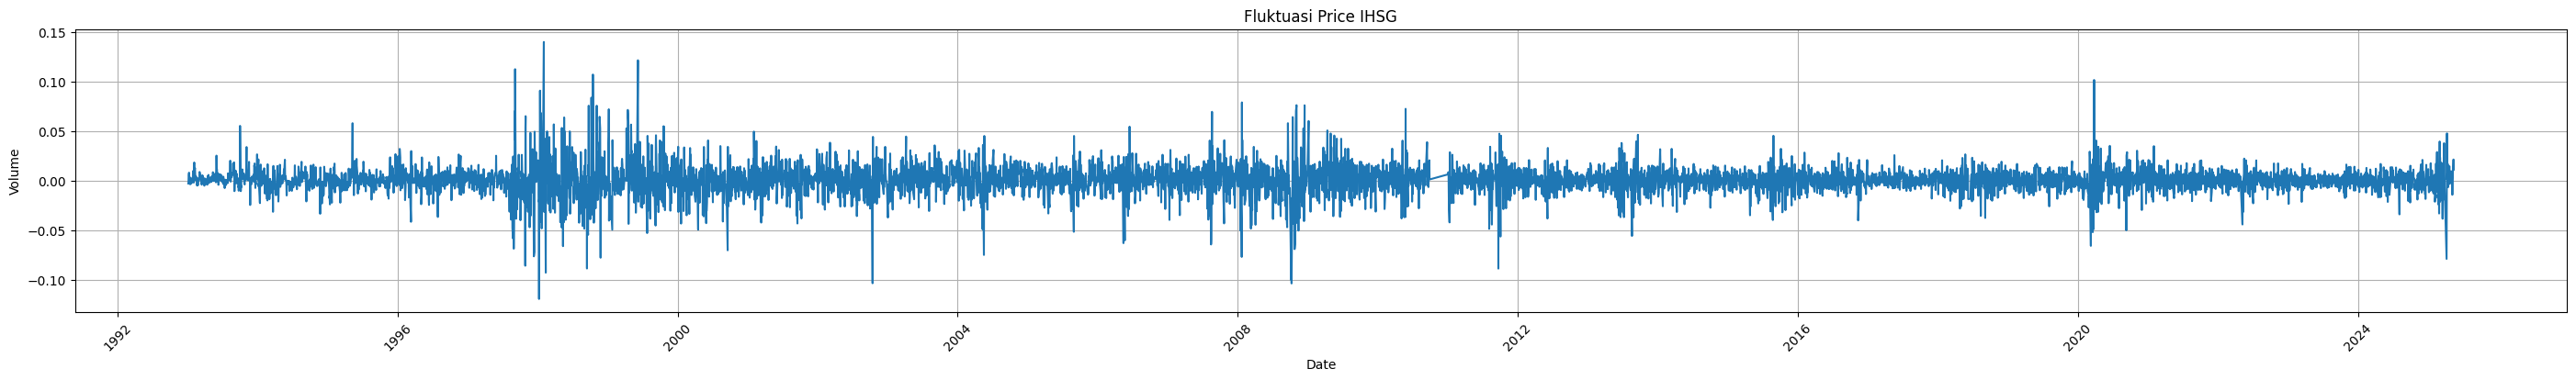

In [16]:
plt.figure(figsize=(35, 4))
sns.lineplot(data=data_ihsg, x="Date", y="Change %", palette="tab10")
plt.title("Fluktuasi Price IHSG")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Berdasarkan persentase perubahan harga IHSG, terjadi naik turun setiap hari nya, jika dilihat periode 1996-2000 terjadi persentase kenaikan dan penurunan yang paling tajam dari tahun lainnya.

# Data Preparation

Variable Price akan distandarisasikan dalam rentang 0 sampai 1 menggunakan Min-Max Scaling

In [17]:
scaler = MinMaxScaler()
data_ihsg["Price"] = scaler.fit_transform(data_ihsg[["Price"]])

Memuat price sebagai bentuk array dari variable Price

In [18]:
date = data_ihsg['Date'].values
price  =data_ihsg['Price'].values

Membuat data train dan data validasi untuk proses modelling dan mengevaluasi hasil model

In [19]:
# 80% untuk train dan 20% untuk validasi
split_time = int(len(price) * 0.8)
train_series = price[:split_time]
val_series = price[split_time:]

Membuat fungsi windowed_dataset_multi dimana Fungsi ini membagi data time series menjadi window input dan target output untuk keperluan pelatihan model multi-step forecasting.

In [20]:
def windowed_dataset_multi(series, window_size, output_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + output_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + output_size))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:window_size], w[window_size:]))
    return ds.batch(batch_size).prefetch(1)

Membentuk train_set dan val_set dengan window input 30 dan target output 60, dibagi dalam batch dan diacak agar siap digunakan untuk pelatihan model

In [21]:
window_size = 30
output_size = 60
batch_size=100
shuffle_buffer=1000

train_set = windowed_dataset_multi(train_series, window_size, output_size, batch_size, shuffle_buffer)
val_set = windowed_dataset_multi(val_series, window_size, output_size, batch_size, shuffle_buffer)

# Modelling

### LSTM without Tunning

In [23]:
# Membangun model LSTM untuk prediksi multi-step IHSG dengan 3 lapis layer
model_lstm = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(60),
])
# Optimizer Adam dengan learning rate kecil
optimizer = tf.keras.optimizers.Adam(learning_rate=1.0000e-04)

# dengan patience 5 akan mengehntikan training saat val_loss tidak membaik selama 5 epoch
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Simpan model terbaik berdasarkan val_loss
model_ckpt = ModelCheckpoint('best_model_lstm.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Callback saat dipake pada training
callbacks = [early_stop, model_ckpt]

# Compile model dengan loss MSE dan metric MAE
model_lstm.compile(loss='mse', optimizer=optimizer, metrics=["mae"])

In [24]:
# training model

history_lstm = model_lstm.fit(train_set,validation_data=val_set, epochs=100, callbacks=callbacks)

Epoch 1/100
     61/Unknown 10s 80ms/step - loss: 0.0266 - mae: 0.0868

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.56740, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - loss: 0.0292 - mae: 0.0914 - val_loss: 0.5674 - val_mae: 0.7393
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0215 - mae: 0.0725
Epoch 2: val_loss improved from 0.56740 to 0.41482, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - loss: 0.0225 - mae: 0.0743 - val_loss: 0.4148 - val_mae: 0.5863
Epoch 3/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0204 - mae: 0.0950
Epoch 3: val_loss improved from 0.41482 to 0.31146, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - loss: 0.0218 - mae: 0.0972 - val_loss: 0.3115 - val_mae: 0.4753
Epoch 4/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0125 - mae: 0.0651
Epoch 4: val_loss improved from 0.31146 to 0.22703, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 0.0135 - mae: 0.0670 - val_loss: 0.2270 - val_mae: 0.3822
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0079 - mae: 0.0369
Epoch 5: val_loss improved from 0.22703 to 0.16025, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 0.0082 - mae: 0.0377 - val_loss: 0.1602 - val_mae: 0.3058
Epoch 6/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0049 - mae: 0.0280
Epoch 6: val_loss improved from 0.16025 to 0.10642, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - loss: 0.0054 - mae: 0.0294 - val_loss: 0.1064 - val_mae: 0.2486
Epoch 7/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0029 - mae: 0.0239
Epoch 7: val_loss improved from 0.10642 to 0.06673, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.0031 - mae: 0.0249 - val_loss: 0.0667 - val_mae: 0.2005
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0017 - mae: 0.0216
Epoch 8: val_loss improved from 0.06673 to 0.04188, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0018 - mae: 0.0219 - val_loss: 0.0419 - val_mae: 0.1664
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0011 - mae: 0.0203    
Epoch 9: val_loss improved from 0.04188 to 0.02849, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 253ms/step - loss: 0.0011 - mae: 0.0205 - val_loss: 0.0285 - val_mae: 0.1430
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 8.0533e-04 - mae: 0.0198
Epoch 10: val_loss improved from 0.02849 to 0.02061, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - loss: 8.2412e-04 - mae: 0.0199 - val_loss: 0.0206 - val_mae: 0.1242
Epoch 11/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 6.8632e-04 - mae: 0.0195
Epoch 11: val_loss improved from 0.02061 to 0.01608, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 7.0930e-04 - mae: 0.0197 - val_loss: 0.0161 - val_mae: 0.1105
Epoch 12/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 6.2820e-04 - mae: 0.0187
Epoch 12: val_loss improved from 0.01608 to 0.01394, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - loss: 6.3682e-04 - mae: 0.0188 - val_loss: 0.0139 - val_mae: 0.1035
Epoch 13/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 5.6796e-04 - mae: 0.0178
Epoch 13: val_loss improved from 0.01394 to 0.01299, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - loss: 5.7518e-04 - mae: 0.0179 - val_loss: 0.0130 - val_mae: 0.1013
Epoch 14/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 5.0225e-04 - mae: 0.0165
Epoch 14: val_loss improved from 0.01299 to 0.01118, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 5.0882e-04 - mae: 0.0165 - val_loss: 0.0112 - val_mae: 0.0931
Epoch 15/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 4.6337e-04 - mae: 0.0158
Epoch 15: val_loss improved from 0.01118 to 0.00973, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - loss: 4.6920e-04 - mae: 0.0159 - val_loss: 0.0097 - val_mae: 0.0859
Epoch 16/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 4.2884e-04 - mae: 0.0149
Epoch 16: val_loss improved from 0.00973 to 0.00830, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - loss: 4.3457e-04 - mae: 0.0150 - val_loss: 0.0083 - val_mae: 0.0778
Epoch 17/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 3.9997e-04 - mae: 0.0142
Epoch 17: val_loss improved from 0.00830 to 0.00737, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - loss: 4.0547e-04 - mae: 0.0143 - val_loss: 0.0074 - val_mae: 0.0723
Epoch 18/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 3.7091e-04 - mae: 0.0134
Epoch 18: val_loss improved from 0.00737 to 0.00712, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - loss: 3.7642e-04 - mae: 0.0135 - val_loss: 0.0071 - val_mae: 0.0713
Epoch 19/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 3.4342e-04 - mae: 0.0127
Epoch 19: val_loss improved from 0.00712 to 0.00626, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 3.5446e-04 - mae: 0.0129 - val_loss: 0.0063 - val_mae: 0.0652
Epoch 20/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 3.3927e-04 - mae: 0.0126
Epoch 20: val_loss improved from 0.00626 to 0.00583, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 3.5004e-04 - mae: 0.0128 - val_loss: 0.0058 - val_mae: 0.0623
Epoch 21/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 3.2537e-04 - mae: 0.0122
Epoch 21: val_loss did not improve from 0.00583
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - loss: 3.3630e-04 - mae: 0.0123 - val_loss: 0.0059 - val_mae: 0.0632
Epoch 22/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 3.1270e-04 - mae: 0.0119
Epoch 22: val_loss improved from 0.00583 to 0.00537, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - loss: 3.2378e-04 - mae: 0.0121 - val_loss: 0.0054 - val_mae: 0.0592
Epoch 23/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 3.1596e-04 - mae: 0.0117
Epoch 23: val_loss improved from 0.00537 to 0.00536, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 3.2700e-04 - mae: 0.0119 - val_loss: 0.0054 - val_mae: 0.0595
Epoch 24/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 3.0559e-04 - mae: 0.0115
Epoch 24: val_loss improved from 0.00536 to 0.00500, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - loss: 3.1097e-04 - mae: 0.0116 - val_loss: 0.0050 - val_mae: 0.0566
Epoch 25/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 2.9386e-04 - mae: 0.0113
Epoch 25: val_loss improved from 0.00500 to 0.00489, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 3.0465e-04 - mae: 0.0114 - val_loss: 0.0049 - val_mae: 0.0559
Epoch 26/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 2.9400e-04 - mae: 0.0113
Epoch 26: val_loss improved from 0.00489 to 0.00466, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - loss: 3.0500e-04 - mae: 0.0115 - val_loss: 0.0047 - val_mae: 0.0539
Epoch 27/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 2.9626e-04 - mae: 0.0111
Epoch 27: val_loss did not improve from 0.00466
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 3.0166e-04 - mae: 0.0112 - val_loss: 0.0047 - val_mae: 0.0545
Epoch 28/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 2.8849e-04 - mae: 0.0109
Epoch 28: val_loss improved from 0.00466 to 0.00453, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 2.9942e-04 - mae: 0.0111 - val_loss: 0.0045 - val_mae: 0.0531
Epoch 29/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.0630e-04 - mae: 0.0114
Epoch 29: val_loss improved from 0.00453 to 0.00449, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - loss: 3.1715e-04 - mae: 0.0115 - val_loss: 0.0045 - val_mae: 0.0529
Epoch 30/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 2.9474e-04 - mae: 0.0110
Epoch 30: val_loss improved from 0.00449 to 0.00416, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 3.0008e-04 - mae: 0.0111 - val_loss: 0.0042 - val_mae: 0.0498
Epoch 31/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 2.9118e-04 - mae: 0.0110
Epoch 31: val_loss did not improve from 0.00416
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 3.0216e-04 - mae: 0.0112 - val_loss: 0.0045 - val_mae: 0.0535
Epoch 32/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 2.7078e-04 - mae: 0.0105
Epoch 32: val_loss improved from 0.00416 to 0.00390, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 2.8227e-04 - mae: 0.0107 - val_loss: 0.0039 - val_mae: 0.0473
Epoch 33/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 2.8615e-04 - mae: 0.0107
Epoch 33: val_loss did not improve from 0.00390
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 2.9740e-04 - mae: 0.0109 - val_loss: 0.0040 - val_mae: 0.0482
Epoch 34/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 2.9072e-04 - mae: 0.0110
Epoch 34: val_loss did not improve from 0.00390
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 2.9614e-04 - mae: 0.0111 - val_loss: 0.0043 - val_mae: 0.0523
Epoch 35/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 2.7420e-04 - mae: 0.0104
Epoch 35: val_loss did not improve from 0.00390
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - loss: 2.7959e-04 - mae: 0.0105 - val_loss: 0.0040 - val_mae: 0.0486
Epoch 36/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 2.7149e-04 - mae: 0.0104
Epoch 36: val_loss improved from 0.00390 to 0.00383, saving model to 

62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - loss: 2.7697e-04 - mae: 0.0105 - val_loss: 0.0038 - val_mae: 0.0470
Epoch 37/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 2.7663e-04 - mae: 0.0107
Epoch 37: val_loss did not improve from 0.00383
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 2.8751e-04 - mae: 0.0108 - val_loss: 0.0042 - val_mae: 0.0512
Epoch 38/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 2.7869e-04 - mae: 0.0105
Epoch 38: val_loss did not improve from 0.00383
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 2.8407e-04 - mae: 0.0106 - val_loss: 0.0040 - val_mae: 0.0493
Epoch 39/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 2.7434e-04 - mae: 0.0104
Epoch 39: val_loss improved from 0.00383 to 0.00379, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 2.7968e-04 - mae: 0.0105 - val_loss: 0.0038 - val_mae: 0.0470
Epoch 40/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 2.8466e-04 - mae: 0.0106
Epoch 40: val_loss improved from 0.00379 to 0.00364, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 2.9528e-04 - mae: 0.0108 - val_loss: 0.0036 - val_mae: 0.0456
Epoch 41/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 2.7174e-04 - mae: 0.0106
Epoch 41: val_loss did not improve from 0.00364
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 2.8242e-04 - mae: 0.0108 - val_loss: 0.0038 - val_mae: 0.0469
Epoch 42/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 2.7092e-04 - mae: 0.0105
Epoch 42: val_loss did not improve from 0.00364
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - loss: 2.7631e-04 - mae: 0.0106 - val_loss: 0.0037 - val_mae: 0.0464
Epoch 43/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 2.8423e-04 - mae: 0.0104
Epoch 43: val_loss improved from 0.00364 to 0.00356, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 2.9582e-04 - mae: 0.0106 - val_loss: 0.0036 - val_mae: 0.0448
Epoch 44/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 2.8997e-04 - mae: 0.0110
Epoch 44: val_loss improved from 0.00356 to 0.00353, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 3.0053e-04 - mae: 0.0112 - val_loss: 0.0035 - val_mae: 0.0448
Epoch 45/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 2.7347e-04 - mae: 0.0106
Epoch 45: val_loss improved from 0.00353 to 0.00330, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 2.7886e-04 - mae: 0.0107 - val_loss: 0.0033 - val_mae: 0.0420
Epoch 46/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 3.0715e-04 - mae: 0.0110
Epoch 46: val_loss did not improve from 0.00330
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - loss: 3.1263e-04 - mae: 0.0111 - val_loss: 0.0035 - val_mae: 0.0441
Epoch 47/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 2.7737e-04 - mae: 0.0108
Epoch 47: val_loss did not improve from 0.00330
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 2.8261e-04 - mae: 0.0109 - val_loss: 0.0034 - val_mae: 0.0440
Epoch 48/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 2.7464e-04 - mae: 0.0103
Epoch 48: val_loss did not improve from 0.00330
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 2.8007e-04 - mae: 0.0104 - val_loss: 0.0034 - val_mae: 0.0439
Epoch 49/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 2.7217e-04 - mae: 0.0107
Epoch 49: val_loss did not improve from 0.00330
62/62 ━━━━━━━━━━━━━━━

62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 2.9016e-04 - mae: 0.0107 - val_loss: 0.0032 - val_mae: 0.0419
Epoch 51/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 2.7983e-04 - mae: 0.0108
Epoch 51: val_loss did not improve from 0.00325
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 2.9015e-04 - mae: 0.0109 - val_loss: 0.0033 - val_mae: 0.0426
Epoch 52/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 2.7784e-04 - mae: 0.0107
Epoch 52: val_loss did not improve from 0.00325
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 2.8828e-04 - mae: 0.0108 - val_loss: 0.0037 - val_mae: 0.0472
Epoch 53/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 2.5592e-04 - mae: 0.0102
Epoch 53: val_loss improved from 0.00325 to 0.00324, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 2.6691e-04 - mae: 0.0104 - val_loss: 0.0032 - val_mae: 0.0420
Epoch 54/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 2.6574e-04 - mae: 0.0102
Epoch 54: val_loss did not improve from 0.00324
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 2.7627e-04 - mae: 0.0103 - val_loss: 0.0033 - val_mae: 0.0432
Epoch 55/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 2.6605e-04 - mae: 0.0105
Epoch 55: val_loss did not improve from 0.00324
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 2.7113e-04 - mae: 0.0106 - val_loss: 0.0034 - val_mae: 0.0443
Epoch 56/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 2.5535e-04 - mae: 0.0100
Epoch 56: val_loss improved from 0.00324 to 0.00307, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 2.6049e-04 - mae: 0.0101 - val_loss: 0.0031 - val_mae: 0.0401
Epoch 57/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 2.6626e-04 - mae: 0.0102
Epoch 57: val_loss improved from 0.00307 to 0.00302, saving model to best_model_lstm.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 2.7168e-04 - mae: 0.0103 - val_loss: 0.0030 - val_mae: 0.0396
Epoch 58/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 2.7036e-04 - mae: 0.0105
Epoch 58: val_loss did not improve from 0.00302
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 2.7547e-04 - mae: 0.0105 - val_loss: 0.0031 - val_mae: 0.0409
Epoch 59/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 2.6316e-04 - mae: 0.0103
Epoch 59: val_loss did not improve from 0.00302
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 2.7346e-04 - mae: 0.0105 - val_loss: 0.0030 - val_mae: 0.0400
Epoch 60/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 2.8918e-04 - mae: 0.0112 
Epoch 60: val_loss did not improve from 0.00302
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - loss: 2.9958e-04 - mae: 0.0113 - val_loss: 0.0030 - val_mae: 0.0400
Epoch 61/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 2.8202e-04 - mae: 0.0108
Epoch 61: val_loss did not improve from 0.00302
62/62 ━━━━━━━━━━━━━

### LSTM With Tunning

In [27]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(
        hp.Int("lstm_units_1", min_value=32, max_value=128, step=32),
        return_sequences=True
    ))
    model.add(tf.keras.layers.LSTM(
        hp.Int("lstm_units_2", min_value=16, max_value=64, step=16)
    ))
    model.add(tf.keras.layers.Dense(
        hp.Int("dense_units", min_value=32, max_value=128, step=32),
        activation="relu"
    ))
    model.add(tf.keras.layers.Dense(output_size))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice("learning_rate", [1e-4, 1e-3])
        ),
        loss="mse",
        metrics=["mae"]
    )

    return model


In [28]:
tuner = kt.GridSearch(
    build_model,
    objective="val_loss",
    max_trials=3,
    executions_per_trial=1,
    overwrite=True,
    directory="tuner_dir",
    project_name="ihsg_lstm"
)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Simpan model terbaik berdasarkan val_loss
model_ckpt = ModelCheckpoint('best_model_lstm_with_tunnin.h5', monitor='val_loss', save_best_only=True, verbose=1)


In [29]:
tuner.search(train_set, validation_data=val_set, epochs=50, callbacks=[early_stop])

Trial 3 Complete [00h 04m 50s]
val_loss: 0.004250258672982454

Best val_loss So Far: 0.0026197065599262714
Total elapsed time: 00h 12m 15s


kode diatas adalah menjallankan proses pencarian hyperparamtere terbaik untuk model yang telah dibuat oleh build_model()

In [33]:
best_hps = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hps)
print("Best LSTM units 1:", best_hps.get("lstm_units_1"))
print("Best LSTM units 2:", best_hps.get("lstm_units_2"))
print("Best Dense units:", best_hps.get("dense_units"))
print("Best Learning rate:", best_hps.get("learning_rate"))


Best LSTM units 1: 32
Best LSTM units 2: 16
Best Dense units: 32
Best Learning rate: 0.001


Hasil hyperparamter terbaiik adalah
- Layer LSTM pertama menggunakan 32 neuron.
- Layer LSTM kedua menggunakan 16 neuron.
- Layer Dense menggunakan 32 neuron.
- Optimizer Adam menggunakan learning rate 0.001, yang lebih cepat daripada 0.0001, dan memberikan hasil terbaik.

In [34]:
history_lstm_with_tunning = best_model.fit(train_set, validation_data=val_set, epochs=100, callbacks = [early_stop, model_ckpt])


Epoch 1/100
     60/Unknown 7s 43ms/step - loss: 0.0074 - mae: 0.0477

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss did not improve from 0.00231
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0080 - mae: 0.0496 - val_loss: 0.0270 - val_mae: 0.1226
Epoch 2/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0017 - mae: 0.0328
Epoch 2: val_loss did not improve from 0.00231
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0017 - mae: 0.0328 - val_loss: 0.0070 - val_mae: 0.0698
Epoch 3/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 9.4090e-04 - mae: 0.0239
Epoch 3: val_loss did not improve from 0.00231
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - loss: 9.4774e-04 - mae: 0.0240 - val_loss: 0.0055 - val_mae: 0.0607
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 5.2490e-04 - mae: 0.0174
Epoch 4: val_loss did not improve from 0.00231
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 5.2969e-04 - mae: 0.0175 - val_loss: 0.0049 - val_mae: 0.0569
Epoch 5/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 3.4524e-04 - mae: 0.0129
Epoch 5: val_loss did not improve from 0.

# Evaluasi

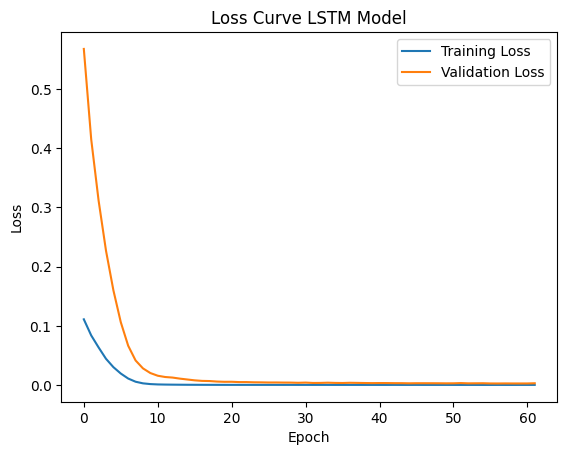

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 3.1576e-04 - mae: 0.0117
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0030 - mae: 0.0383


In [35]:
# Melihat grafik kurva Loss
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve LSTM Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Mengetahaui perbandingan skor train dan val
train_score_lstm = model_lstm.evaluate(train_set)
val_score_lstm = model_lstm.evaluate(val_set)


**Analisis Grafik:**
- Train dan validation loss sama sama turun dratis terus mendatar di nilai yang sangat kecil
- Tidak ada gap besar
- Validation loss sedikit lebih tinggi dari training loss, tapi polanya mengikuti dan stabil, tidak naik tajam di akhir epoch.

**Analisis Score:**
- nilai  loss dan mae pada training dan validasi sama sama kecil
- mae validasi sedikit lebih tinggi dari training tapi gap nya tidak besar
- Tidak ada tanda overfitting (yaitu training loss jauh lebih kecil dari validation loss).
- Tidak ada tanda underfitting (yaitu loss tidak turun atau tetap tinggi).

**Kesimpulan:**
- Model LSTM Tidak Overfitting dan Underfitting
- Model baik dan bisa digunakan untuk prediksi




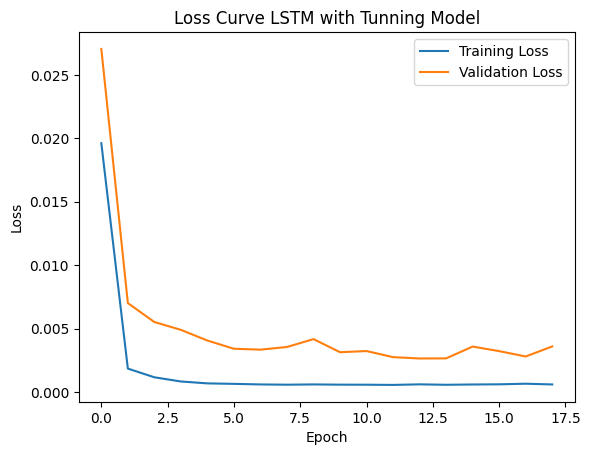

62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.6901e-04 - mae: 0.0099
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0027 - mae: 0.0359


In [36]:
# Melihat grafik kurva Loss
plt.plot(history_lstm_with_tunning.history['loss'], label='Training Loss')
plt.plot(history_lstm_with_tunning.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve LSTM with Tunning Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Mengetahaui perbandingan skor train dan val
train_score_lstm_tunning =best_model.evaluate(train_set)
val_score_lstm_tunning = best_model.evaluate(val_set)


**Analisis Grafik:**
- Train dan validation loss sama sama turun dengan cepaat dan kemudian mendatar di angka kecil
- Tidak ada gap besar
- Validation loss sedikit lebih tinggi dari training loss, tapi polanya mengikuti dan stabil, tidak naik tajam di akhir epoch.

**Analisis Score:**
- nilai  loss dan mae pada training dan validasi sama sama kecil
- mae validasi sedikit lebih tinggi dari training tapi gap nya tidak besar
- Tidak ada tanda overfitting (yaitu training loss jauh lebih kecil dari validation loss).
- Validation MAE juga masih cukup rendah.

**Kesimpulan:**
- Model LSTM Tidak Overfitting dan Underfitting
- Model baik dan bisa digunakan untuk prediksi




**Perbandingan**

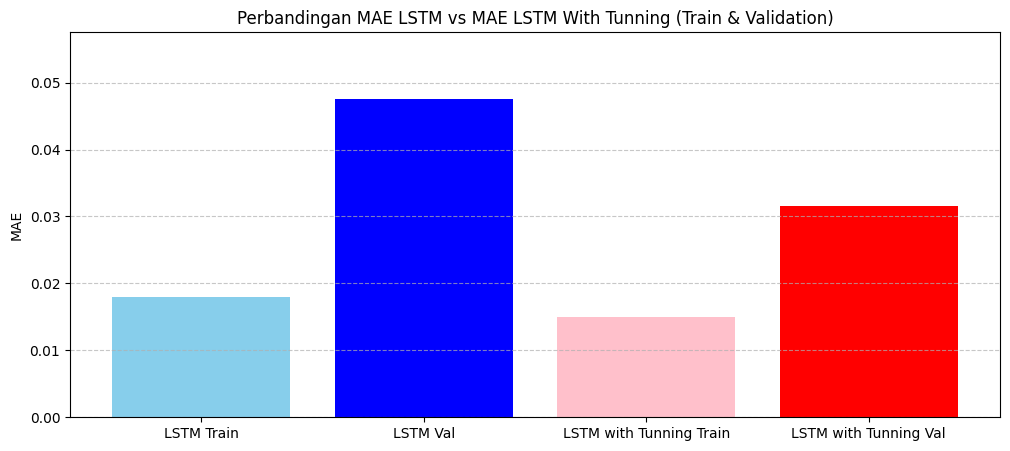

In [ ]:
mae_scores = {
    'LSTM Train': train_score_lstm[1],
    'LSTM Val': val_score_lstm[1],
    'LSTM with Tunning Train': train_score_lstm_tunning[1],
    'LSTM with Tunning Val': val_score_lstm_tunning[1]
}

plt.figure(figsize=(12, 5))
plt.bar(mae_scores.keys(), mae_scores.values(), color=['skyblue', 'blue', 'pink', 'red'])
plt.ylabel('MAE')
plt.title('Perbandingan MAE LSTM vs MAE LSTM With Tunning (Train & Validation)')
plt.ylim(0, max(mae_scores.values()) + 0.01)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Model LSTM with Tunning memiliki MAE yang lebih rendah dari LSTM without tunning baik dari train dan validation. maka LSTM with Tunning model yang paling baik untuk prediksi

# Result

**Melakukan prediksi selama 60 hari kedepan**

In [37]:
# Ambil 60 data terakhir dari data asli (seluruh price yang sudah diskalakan)
last_window = price[-60:]
last_window = np.expand_dims(last_window, axis=(0, 2))

In [38]:
# Lakukan prediksi ke depan 60 hari menggunkan model cnn
future_pred_scaled = best_model.predict(last_window)
future_pred_scaled = future_pred_scaled.flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


In [39]:
# Inverse hasil prediksi ke skala asli
future_pred = scaler.inverse_transform(future_pred_scaled.reshape(-1, 1)).flatten()

In [40]:
# Buat range tanggal prediksi 60 hari ke depan
last_date = pd.to_datetime(data_ihsg["Date"].iloc[-1])
future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 61)]

In [41]:
# Simpan hasil prediksi ke DataFrame
future_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted_IHSG": future_pred
})

In [42]:
future_df

,Date,Predicted_IHSG
0,2025-05-16,6548.266602
1,2025-05-17,6567.181152
2,2025-05-18,6707.973633
3,2025-05-19,6592.432129
4,2025-05-20,6587.477051
5,2025-05-21,6681.831055
6,2025-05-22,6636.324219
7,2025-05-23,6590.982422
8,2025-05-24,6672.368164
9,2025-05-25,6553.041504


**Visualisasi Hasil**

In [43]:
# Inverse -- cukup 1x run
data_ihsg["Price"] = scaler.inverse_transform(data_ihsg[["Price"]])

In [44]:
# Ambil 60 hari terakhir data historis
historical_60 = data_ihsg.tail(60).copy()

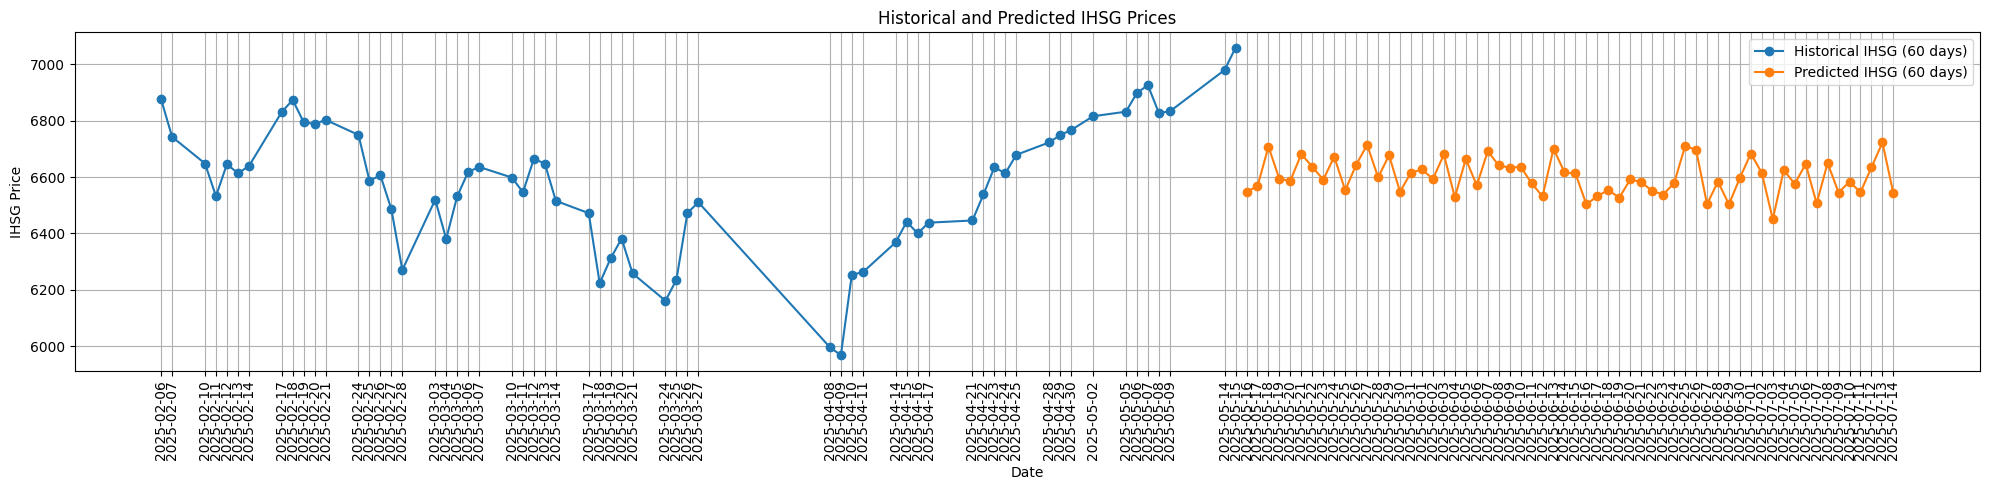

In [45]:
# Gabungkan semua tanggal (historis dan prediksi)
all_dates = pd.concat([historical_60['Date'], future_df['Date']])

plt.figure(figsize=(20, 5))
plt.plot(historical_60['Date'], historical_60['Price'], label='Historical IHSG (60 days)', marker='o')
plt.plot(future_df['Date'], future_df['Predicted_IHSG'], label='Predicted IHSG (60 days)', marker='o')

plt.xlabel('Date')
plt.ylabel('IHSG Price')
plt.title('Historical and Predicted IHSG Prices')
plt.legend()
plt.grid(True)

# Tampilkan semua tanggal pada sumbu X secara jelas
plt.xticks(ticks=all_dates, labels=all_dates.dt.strftime('%Y-%m-%d'), rotation=90)

plt.tight_layout()
plt.show()

pada line orange merupakan Hasil dari Prediksi selama 60 hari

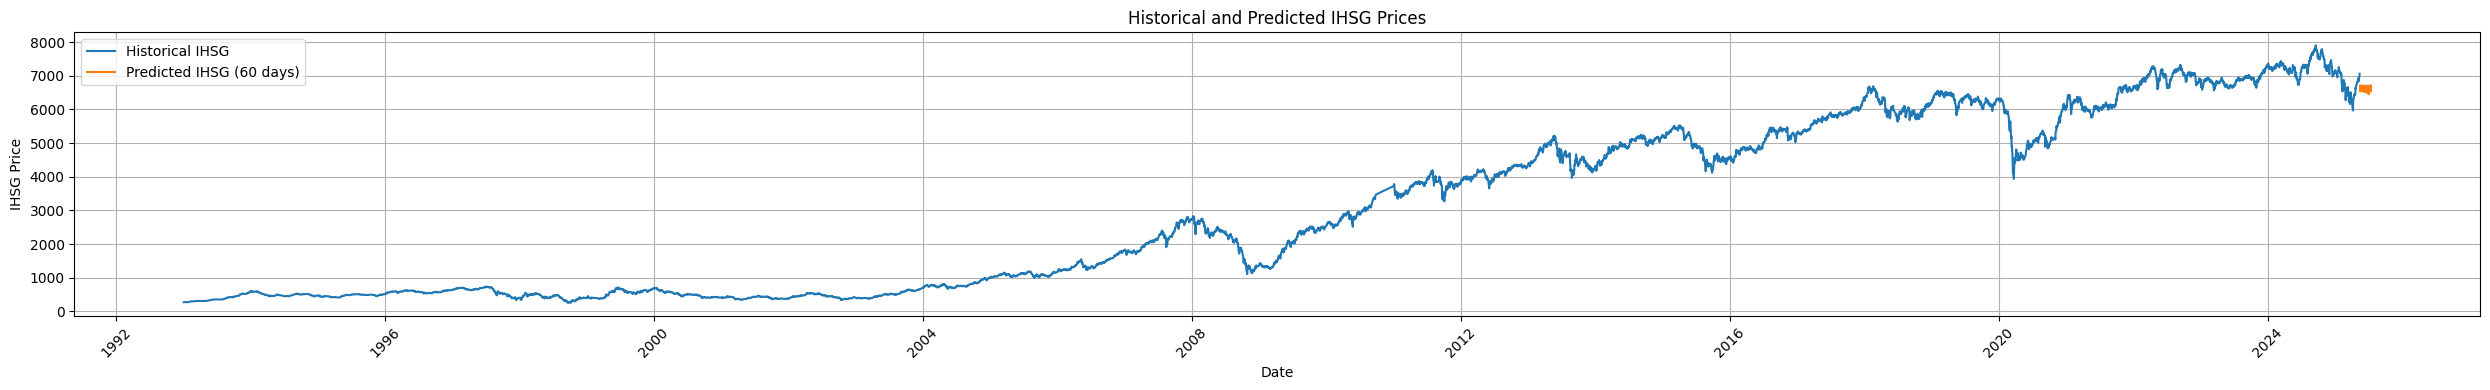

In [46]:
# Ambil 60 hari terakhir data historis (harga asli)
# historical_60 = data_ihsg.tail(60).copy()

# Data prediksi 60 hari ke depan sudah ada di future_df (kolom "Predicted_IHSG")
# Plot data historis dan prediksi
plt.figure(figsize=(25, 4))
plt.plot(data_ihsg['Date'], data_ihsg['Price'], label='Historical IHSG')
plt.plot(future_df['Date'], future_df['Predicted_IHSG'], label='Predicted IHSG (60 days)')
plt.xlabel('Date')
plt.ylabel('IHSG Price')
plt.title('Historical and Predicted IHSG Prices')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()